In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

## Getting set up

In [2]:
comp = 'playground-series-s3e25'
path = setup_comp(comp, install='')

In [3]:
path

Path('playground-series-s3e25')

In [4]:
trn_path = path/'train.csv'

In [31]:
from fastai.tabular.all import *
from fastai.data.all import *
import pandas as pd

df = pd.read_csv(trn_path)

In [25]:
df

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10402,10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8
10405,10405,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0


In [26]:
cont_names = df.iloc[:,1:-1].columns.to_list()
cat_names = []
procs = [Normalize]
splits = RandomSplitter()(range_of(df))

In [27]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="Hardness", splits=splits, y_block=RegressionBlock)

In [29]:
dls = to.dataloaders(bs=64)
dls.show_batch()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,192.000000,30.821995,49.000000,5.000000,119.629501,8.213150,2.298000,1.910000,1.184000,0.467304,6.31300,2.5
1,64.000000,10.207996,32.000000,5.000000,74.718704,11.177140,2.445000,1.765000,0.945000,0.462985,5.09880,2.0
2,43.000000,7.876748,10.750000,3.750000,22.212725,12.027800,2.727500,1.625000,0.710000,0.614430,1.49127,5.3
3,14.000000,1.740168,4.666666,1.333333,8.862139,13.652933,2.660000,1.310000,0.680000,0.825990,0.52252,2.5
4,415.000000,35.301964,10.878048,4.804878,20.994127,10.966795,2.715366,1.527073,0.851707,0.496533,0.75755,5.5
5,107.000000,12.417996,11.600000,4.800000,24.750879,11.330440,2.706000,1.907200,0.928000,0.498666,1.00104,5.5
6,46.000000,9.143996,23.000000,4.800000,56.980888,11.496917,2.810000,1.742000,0.956000,0.476095,4.90209,6.0
7,58.000000,11.202328,19.333334,4.666667,39.987667,11.556733,2.848333,1.756667,0.893333,0.487833,1.69886,6.3
8,338.000000,36.095295,11.155556,4.444445,22.111242,11.189909,2.821111,1.724444,0.894444,0.490901,0.88120,6.5
9,544.400024,70.098297,5.428572,4.487783,11.990559,11.739439,2.719722,1.541520,0.736617,0.505030,0.68417,5.5


In [48]:
learn = tabular_learner(dls, loss_func=mae, metrics=mae)

In [51]:
learn.fit_one_cycle(12)

epoch,train_loss,valid_loss,mae,time
0,0.933384,0.972781,0.972781,00:01
1,0.949618,0.980479,0.980479,00:01
2,0.959424,0.967790,0.967790,00:01
3,0.963037,0.983448,0.983448,00:01
4,0.970716,0.997507,0.997507,00:01
5,0.957347,0.972419,0.972419,00:01
6,0.941777,0.967837,0.967837,00:01
7,0.919437,0.965841,0.965841,00:01
8,0.923242,0.965976,0.965976,00:01
9,0.929039,0.960516,0.960516,00:01


In [46]:
learn.show_results()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness,Hardness_pred
0,-0.505964,-0.780840,-1.054044,-0.787431,-0.980573,0.230700,-0.165650,-1.196595,-1.077471,0.094029,-0.773102,10.0,5.934103
1,0.043010,-0.183655,-0.347993,-0.211226,-0.307169,0.317069,0.234009,0.104811,-0.026249,0.088575,-0.581272,5.5,5.355187
2,0.117870,0.849700,0.218120,1.133253,0.095063,0.417117,1.017420,-0.077661,-0.284444,-0.314919,0.083077,6.3,4.502938
3,-0.447739,-0.638333,-0.672394,-0.787431,-0.671578,-0.875276,-0.926194,0.869129,0.001415,0.085626,-0.621657,9.5,6.547757
4,0.234319,1.598971,0.567966,0.653082,0.450177,-1.163475,-1.049223,0.694834,1.011141,-0.284306,1.516152,3.0,3.460598
5,-0.144140,-0.333482,-0.147627,0.172911,-0.155841,0.225482,0.440798,0.103090,0.121291,-0.167602,-0.256418,5.8,5.498179
6,0.076281,-0.287019,-0.233498,-0.787431,-0.145162,0.322143,0.776829,-0.189554,-0.878292,1.522863,-0.581272,2.5,5.108125
7,-0.289701,1.425699,0.218120,0.172911,0.095063,-1.263882,-1.388486,0.765843,0.895875,-0.091578,-0.402097,5.8,4.848989
8,-0.056803,0.001176,-0.233498,0.364980,-0.228382,0.280609,0.234009,0.001525,-0.247559,-0.183493,0.334028,6.0,5.471454


In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR


class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.hidden_layers.append(nn.ReLU())
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x


input_size = 12
hidden_sizes = [16, 32]  
output_size = 1 

model = MLPModel(input_size, hidden_sizes, output_size)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=int(len(df)/128), epochs=100)

In [165]:
from torch.utils.data import DataLoader, TensorDataset

features = df.drop('Hardness', axis=1).values
target = df['Hardness'].values.reshape(-1, 1)

In [166]:
# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

In [167]:
# Create a TensorDataset
dataset = TensorDataset(features_tensor, target_tensor)

In [168]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [169]:
# Create DataLoader for training and validation sets
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [170]:
# Rest of the code for training loop and evaluation
num_epochs = 100
lrs = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_features, batch_target in train_loader:
        optimizer.zero_grad()
        output = model(batch_features)
        loss = criterion(output, batch_target)
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

Epoch [1/100], Loss: 4.3521
Epoch [2/100], Loss: 3.8691
Epoch [3/100], Loss: 2.7739
Epoch [4/100], Loss: 1.7125
Epoch [5/100], Loss: 1.4019
Epoch [6/100], Loss: 1.3037
Epoch [7/100], Loss: 1.2459
Epoch [8/100], Loss: 1.1809
Epoch [9/100], Loss: 1.1509
Epoch [10/100], Loss: 1.0878
Epoch [11/100], Loss: 1.0583
Epoch [12/100], Loss: 1.0542
Epoch [13/100], Loss: 1.0696
Epoch [14/100], Loss: 1.0606
Epoch [15/100], Loss: 1.0365
Epoch [16/100], Loss: 1.0246
Epoch [17/100], Loss: 1.0121
Epoch [18/100], Loss: 1.0445
Epoch [19/100], Loss: 1.0251
Epoch [20/100], Loss: 1.0104
Epoch [21/100], Loss: 1.0097
Epoch [22/100], Loss: 1.0063
Epoch [23/100], Loss: 1.0037
Epoch [24/100], Loss: 1.0036
Epoch [25/100], Loss: 0.9963
Epoch [26/100], Loss: 1.0063
Epoch [27/100], Loss: 1.0371
Epoch [28/100], Loss: 1.0035
Epoch [29/100], Loss: 1.0177
Epoch [30/100], Loss: 1.0353
Epoch [31/100], Loss: 0.9893
Epoch [32/100], Loss: 1.0068
Epoch [33/100], Loss: 0.9871
Epoch [34/100], Loss: 0.9972
Epoch [35/100], Loss: 0

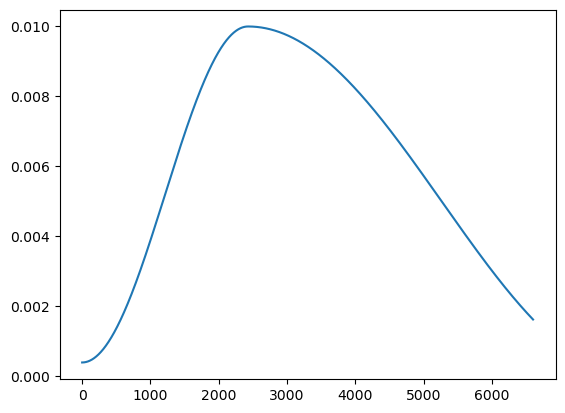

In [171]:
plt.plot(lrs)

In [172]:
# Evaluation
model.eval()
val_loss = 0

with torch.no_grad():
    for batch_features, batch_target in val_loader:
        output = model(batch_features)
        loss = criterion(output, batch_target)
        val_loss += loss.item()

average_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {average_val_loss:.4f}")

Validation Loss: 0.9678


## Submitting to Kaggle

In [27]:
ss = pd.read_csv(path/'sample_submission.csv')

In [28]:
tst = pd.read_csv(path/'test.csv')

In [29]:
ss['Hardness'] = pipe.predict(tst.iloc[:,1:])

In [30]:
ss.to_csv('subm.csv', index=False)
!head subm.csv

id,Hardness
10407,2.2447038862580264
10408,2.9816768410094707
10409,6.057493409630426
10410,4.0252023999737645
10411,6.180580306667615
10412,4.6798035133943365
10413,3.7570595169337735
10414,5.385486430590966
10415,3.173753209604238


In [31]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'MLP', comp)

100%|███████████████████████████████████████████████████████| 164k/164k [00:00<00:00, 185kB/s]


## Conclusion

## Addendum

In [ ]:
if not iskaggle:
    push_notebook('xy', 'mock-first-steps-road-to-the-top-part-1',
                  title='mock First Steps: Road to the Top, Part 1',
                  file='mock-first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)